<font size="5"> <center> <b> Credit Card Default Prediction using various approaches to assess class imbalance.</b> </center> </font>

<p>Ramiro Mejia &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Diego Villacreses</p>
<p>ramiromejiap@gmail.com &emsp;&emsp;&emsp; ddvillacresesz@gmail.com</p>

<hr>

This is a notebook detailing the implementation of six models to maximize a *Bank Revenue* function and compare it to other standard gain and loss functions. We used information of 30,000 Taiwan's customers produced on October 2005, detailed description of the information we used can be found [on the for Machine Learning Repository of University of California, Irvine](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). 

We use as a *Bank Profit* function: $Average Profit_{per costumer} = \frac{ \sum_i(\alpha* True Negative_i - (1-\alpha)*False Negative_i)}{Total True Negative + Total False Negative)}$, where $\alpha$ is a parameter that allow us to impose a relative value of a default client against a non-default. Since we doesn't know $\alpha$ we would train our models with $\alpha = \{1/3, 3/7, 1/2\}$.

This notebook has four sections: i) data loading and handling, ii) exploratory data analysis, iii) modelling, iv) conclusions.

In [1]:
import os
import sys

#Graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo

#Basic
import numpy as np
import pandas as pd

#loss function metrics
from scipy.stats import lognorm, loguniform, randint, uniform
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, make_scorer,
                             precision_score, recall_score,
                             average_precision_score, auc,
                            roc_auc_score,roc_curve,precision_recall_curve,
                            PrecisionRecallDisplay,ConfusionMatrixDisplay)

#model_selection and hyperparameter tunning
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, cross_validate,
                                     train_test_split, cross_val_predict)

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

#Classifiers
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Imbalanced-Learn Library
from imblearn.over_sampling import SMOTE
#
from sklearn.ensemble import BaggingClassifier

#Explain predictions
import eli5
import shap

#For Kendall Correlation
import scipy.stats as stats

C:\Users\Diego\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [2]:
#To save ML sklearn objects
import pickle

## Loading Data, change encoding

In [3]:
os.chdir('C:/Users/Diego/Desktop/MT/Credit_card_default-custom score/data')

In [4]:
# loading data from UCI ML Repository
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
#df = pd.read_excel(url, skiprows=1)
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [5]:
# renaming the target variable
df.rename(columns={"default payment next month": "target"}, inplace=True)

# dropping ID
df.drop(columns='ID', inplace=True)

# Changing numeric encoding to labels
df['SEX'].replace([1, 2], ['Male', 'Female'], inplace=True)

df['MARRIAGE'].replace([1, 2, 3, 0], ['Married', 'Single', 'Other', 'Other'],
                       inplace=True)

df['EDUCATION'].replace([1, 2, 3, 4, 0, 5, 6], 
    ['GraduateSchool', 'University', 'HighSchool', 'Other', 'Other', 'Other','Other'],
                        inplace=True)

In [6]:
# split the data 80/20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)
train_df.shape

(24000, 24)

In [7]:
print("Distribution of the target variable - train data:\n",
      train_df["target"].value_counts(normalize=True),
      sep='')
print("Distribution of the target variable - all data:\n",
      df["target"].value_counts(normalize=True),
      sep='')

Distribution of the target variable - train data:
0    0.779125
1    0.220875
Name: target, dtype: float64
Distribution of the target variable - all data:
0    0.7788
1    0.2212
Name: target, dtype: float64


We have class imbalance in the target variable.

## Exploratory Data Analysis

In [8]:
# Separate X and Y for training and testing
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [10]:
#Compare kendall vs. pearson correlation
#Kendall
l = list(df.columns)
l = len(l)
corr_k = np.zeros([l, l])
corr_k = np.asmatrix(corr_k)
for c1 in range(l):
    for c2 in range(l):
        tau, p_value = stats.kendalltau(df.iloc[:, c1], df.iloc[:, c2])
        tau = round(tau, 3)
        corr_k[c1, c2] = tau

corr_k = pd.DataFrame(corr_k)
corr_k.columns = df.columns
corr_k.index = df.columns
corr_k = corr_k.round(2)
#Pearson
corr = df.corr().round(decimals=2)

In [11]:
fig1 = px.imshow(corr_k.T, color_continuous_scale='viridis', origin='lower', text_auto=True)
fig2 = px.imshow(corr.T, color_continuous_scale='viridis', origin='lower', text_auto=True)
fig1 = fig1.update_layout(title='Matrix correlation - Kendall', height=1000, width = 1000)
fig2 = fig2.update_layout(title='Matrix correlation - Pearson', height=1000, width = 1000)

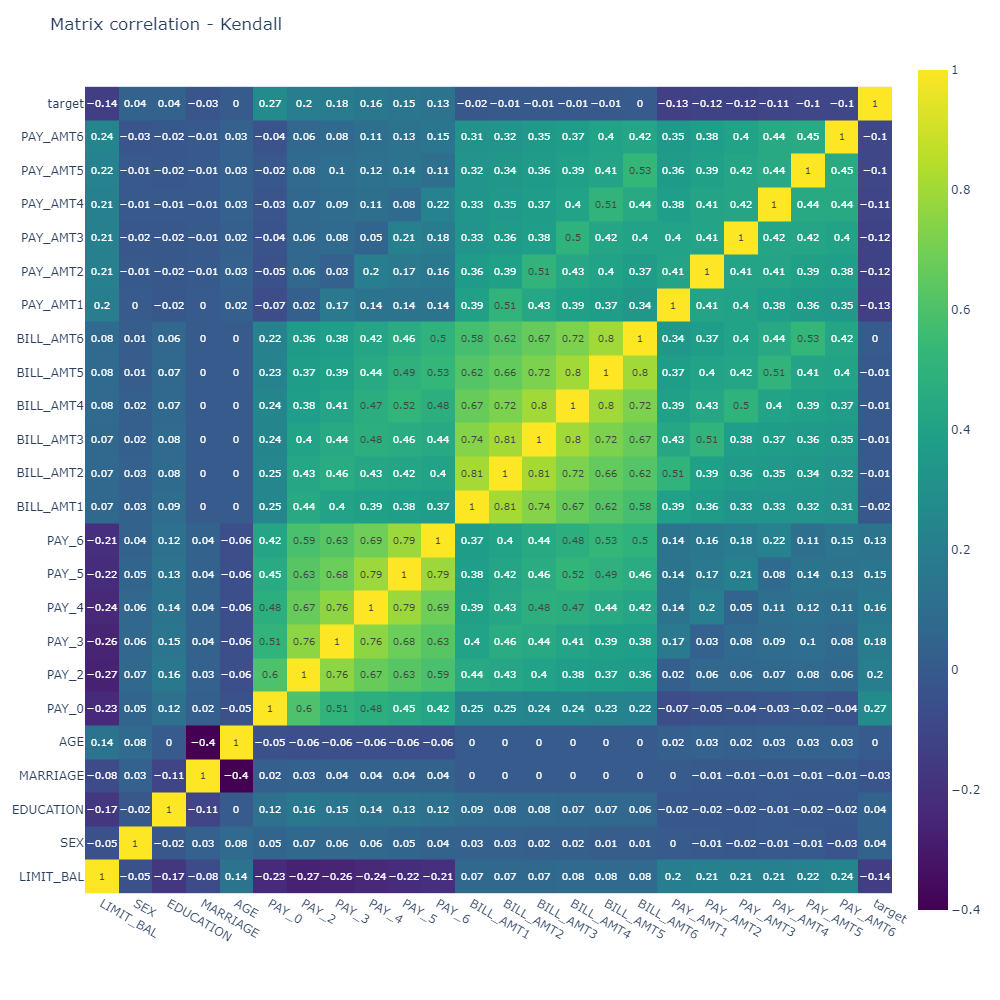

In [12]:
#To see the interactive graph: pyo.iplot(fig1, filename = 'fig1')
fig1.show("png")
    #pip install -U kaleido

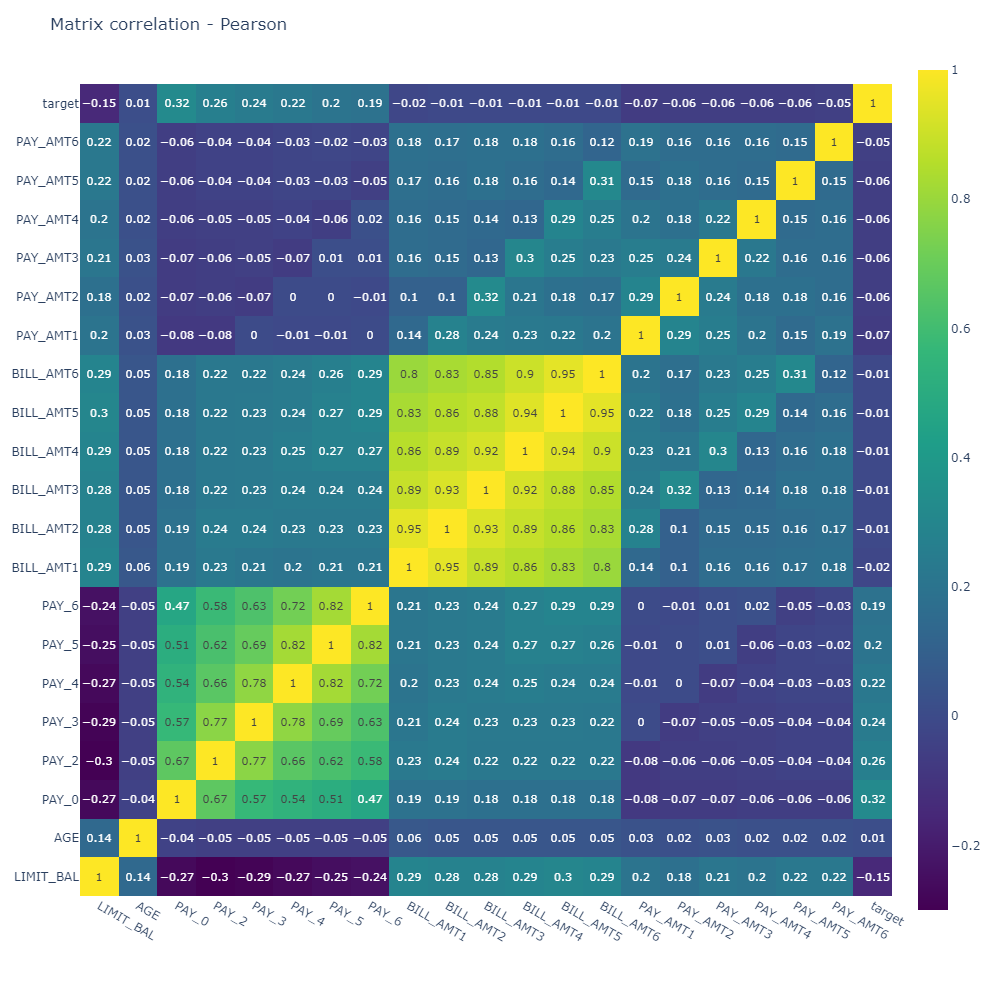

In [13]:
#pyo.iplot(fig2, filename = 'fig2')
fig2.show("png")

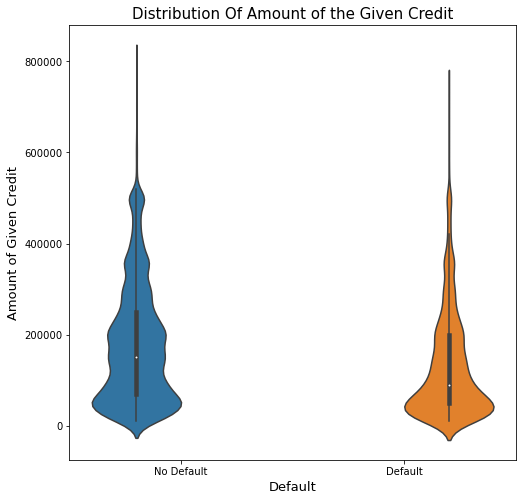

In [14]:
f, ax = plt.subplots(figsize=(8, 8))
violin= sns.violinplot(x="target",
                       y="LIMIT_BAL",
                       hue='target',
               data=train_df)
plt.title('Distribution Of Amount of the Given Credit', fontsize=15)
plt.legend().remove()
plt.xlabel('Default', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'No Default'
labels[1] = 'Default'
ax.set_xticklabels(labels)
plt.show();

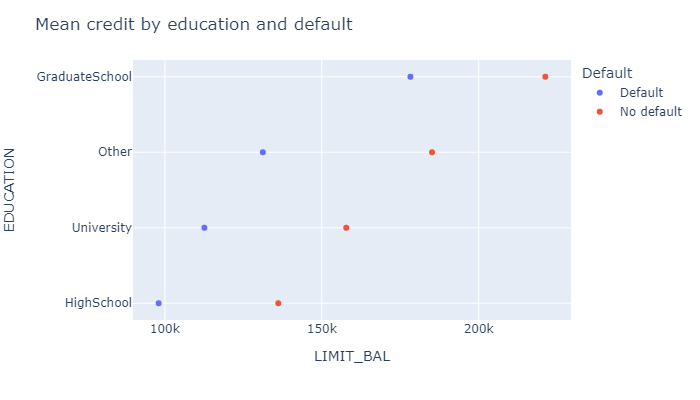

In [15]:
#Mean credit by education and default
tmp = df.loc[:,['LIMIT_BAL','EDUCATION', 'target']].groupby(['target','EDUCATION'],as_index=False).mean('LIMIT_BAL')
cond1 = tmp['target'] == 0
cond2 = tmp['target'] >0
column_name = 'Default'
tmp.loc[cond1, column_name] = 'No default'
tmp.loc[cond2, column_name] = 'Default'
tmp = tmp.sort_values(by = 'LIMIT_BAL',ascending=True)

fig3 = px.scatter(tmp, x="LIMIT_BAL", y="EDUCATION", color="Default")
fig3 = fig3.update_layout(width =700, height=400,title='Mean credit by education and default')

#pyo.iplot(fig3, filename = 'fig3')
fig3.show("png")

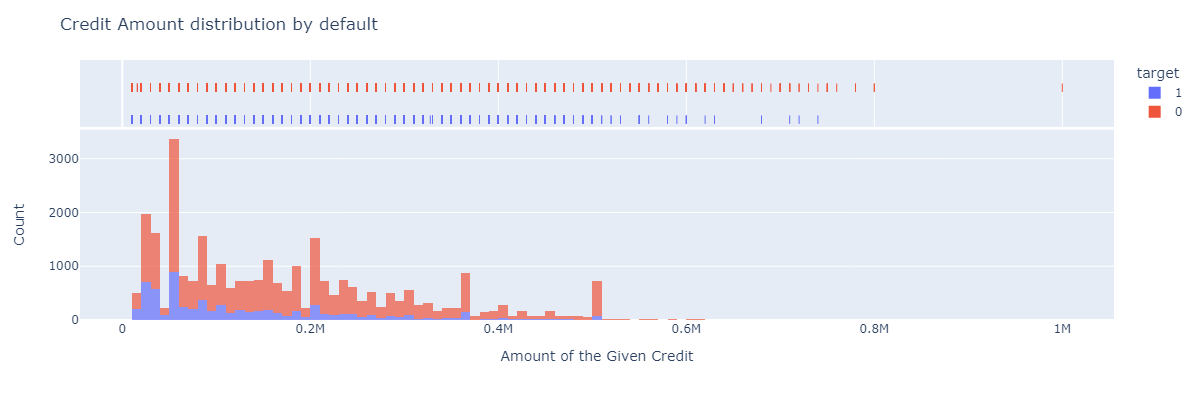

In [16]:
fig4 = px.histogram(df, x="LIMIT_BAL", color="target", marginal="rug", 
                   hover_data=df.columns, nbins=100,
                   opacity=0.7)

fig4 = fig4.update_layout(xaxis_title_text = 'Amount of the Given Credit',
                          yaxis_title_text = 'Count', 
                          title = 'Credit Amount distribution by default',
                          height = 400, width = 1200)

#pyo.iplot(fig4, filename = 'fig4')
fig4.show("png")

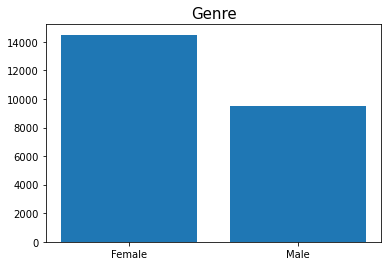

In [17]:
plt.bar(train_df['SEX'].unique().tolist(),
       train_df['SEX'].value_counts().tolist())
plt.title('Genre', fontsize=15);

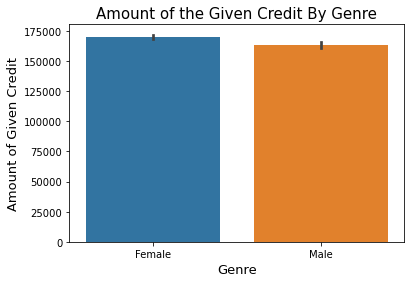

In [18]:
sns.barplot(x = 'SEX',y='LIMIT_BAL',data = df)
plt.xlabel('Genre', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)
plt.title('Amount of the Given Credit By Genre', fontsize=15)
plt.show();

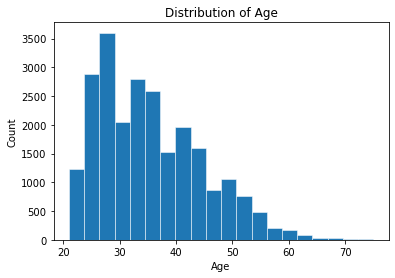

In [19]:
fig, ax = plt.subplots()
ax.hist(train_df['AGE'], bins=20, linewidth=0.5, edgecolor="white")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show();

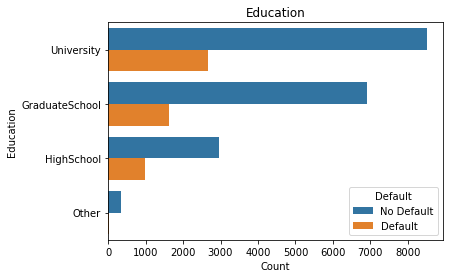

In [20]:
fig, ax = plt.subplots()
ax = sns.countplot(y="EDUCATION", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('Education')
plt.title('Education')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

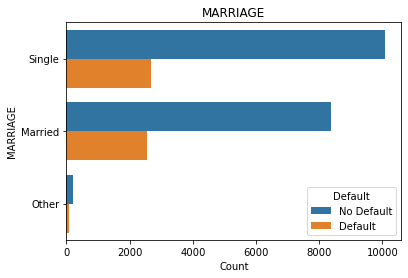

In [21]:
fig, ax = plt.subplots()
ax = sns.countplot(y="MARRIAGE", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('MARRIAGE')
plt.title('MARRIAGE')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

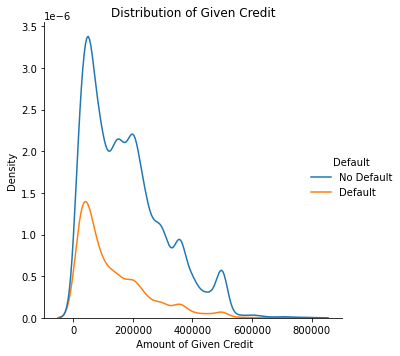

In [22]:
ax = sns.displot(x="LIMIT_BAL", hue="target", data=train_df, kind="kde")
ax.set(xlabel=' Amount of Given Credit', title='Distribution of Given Credit')
ax._legend.set_title('Default')
new_labels = ['No Default', 'Default']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
sns.move_legend(ax, "center right")

## Modelling 

In [23]:
# Separate X and Y for training and testing 
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [24]:
## Code attribution: UBC-MDS DSCI-571 Varada Kolhatkar 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, cv = 10, **kwargs)
    predicts = cross_val_predict(model, X_train, y_train, cv = 10)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    res = pd.Series(data=out_col, index=mean_scores.index)
    return [res,predicts] 

In [25]:
# Preprocessing and transformations

numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']

categorical_features = ["MARRIAGE"]

binary_features = ["SEX"]

ordinal_features = ["EDUCATION"]

education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']


# preprocessor

preprocessor = make_column_transformer(

    (StandardScaler(), numeric_features),

    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

### Custom score metric

In [26]:
#Custom scorer for scikit-learn, resources:
    #https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
    #https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return np.log1p(diff)
#Banks profit:
def bank_profit_f1(y_true, y_pred):
    #earnings = alpha*true_negative - (1-alpha)*false_negative
    alpha = 1/3
    
    true_positive = sum(y_pred[y_pred==y_true] ==1)
    true_negative = sum(y_pred[y_pred==y_true] ==0)
    false_positive = sum(y_pred[y_pred!=y_true] ==1)
    false_negative = sum(y_pred[y_pred!=y_true] ==0)
    
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

def bank_profit_f2(y_true, y_pred):
    alpha = 3/7
    
    true_positive = sum(y_pred[y_pred==y_true] ==1)
    true_negative = sum(y_pred[y_pred==y_true] ==0)
    false_positive = sum(y_pred[y_pred!=y_true] ==1)
    false_negative = sum(y_pred[y_pred!=y_true] ==0)
    
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

def bank_profit_f3(y_true, y_pred):
    alpha = 1/2
    
    true_positive = sum(y_pred[y_pred==y_true] ==1)
    true_negative = sum(y_pred[y_pred==y_true] ==0)
    false_positive = sum(y_pred[y_pred!=y_true] ==1)
    false_negative = sum(y_pred[y_pred!=y_true] ==0)
    
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

bank_profit1 = make_scorer(bank_profit_f1, greater_is_better=True)
bank_profit2 = make_scorer(bank_profit_f2, greater_is_better=True)
bank_profit3 = make_scorer(bank_profit_f3, greater_is_better=True)

In [27]:
# evalution metric for scoring
f1_micro = make_scorer(f1_score, average="micro")

scoring = {
    "profits, a=1/3": bank_profit1,
    "profits, a=3/7": bank_profit2,
    "profits, a=1/2": bank_profit3,
    "f1": f1_micro,
    "recall": "recall",
    "precision": "precision",
    'roc_auc': 'roc_auc'
}

### Using default hyper-parameters

In [28]:
# Dictionary of Results and Predictions
results = {}
preds = {}

#For replicability
random_seed = 1

#To speed up SVM
n_estimators=10

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(random_state=random_seed),
    "SVC_bagged": BaggingClassifier(
        SVC(random_state=random_seed,
            kernel='linear', probability=True, class_weight='balanced'), 
            max_samples=1.0 / n_estimators, n_estimators=n_estimators),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "XGBoost": XGBClassifier(random_state=random_seed, eval_metric="logloss",
                             verbosity=0, use_label_encoder=False,
                             class_weight="balanced", nthread = -1),
    "LightGBM": LGBMClassifier(random_state=random_seed),
    "CatBoost": CatBoostClassifier(verbose=0,
                                   random_state=random_seed)
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    tmp = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )
    results[name] = tmp[0]
    preds[name] = tmp[1]
    
#~50min - rog g14 - amd 4800hs

In [29]:
results_3_2 = pd.DataFrame(results).T

In [30]:
results_3_2

,fit_time,score_time,"test_profits, a=1/3","train_profits, a=1/3","test_profits, a=3/7","train_profits, a=3/7","test_profits, a=1/2","train_profits, a=1/2",test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.215 (+/- 0.008),0.051 (+/- 0.002),0.151 (+/- 0.003),0.151 (+/- 0.001),0.246 (+/- 0.003),0.247 (+/- 0.001),0.318 (+/- 0.003),0.318 (+/- 0.001),0.810 (+/- 0.006),0.811 (+/- 0.001),0.234 (+/- 0.013),0.236 (+/- 0.006),0.719 (+/- 0.048),0.719 (+/- 0.003),0.721 (+/- 0.011),0.723 (+/- 0.002)
SVC,29.912 (+/- 5.543),5.154 (+/- 0.297),0.166 (+/- 0.004),0.169 (+/- 0.001),0.262 (+/- 0.004),0.265 (+/- 0.001),0.333 (+/- 0.004),0.336 (+/- 0.001),0.819 (+/- 0.006),0.824 (+/- 0.001),0.321 (+/- 0.019),0.335 (+/- 0.006),0.695 (+/- 0.033),0.717 (+/- 0.006),0.720 (+/- 0.011),0.778 (+/- 0.002)
SVC_bagged,13.641 (+/- 0.600),2.401 (+/- 0.235),0.133 (+/- 0.004),0.133 (+/- 0.003),0.229 (+/- 0.004),0.229 (+/- 0.003),0.300 (+/- 0.004),0.300 (+/- 0.003),0.797 (+/- 0.004),0.797 (+/- 0.003),0.131 (+/- 0.021),0.130 (+/- 0.016),0.736 (+/- 0.051),0.731 (+/- 0.008),0.720 (+/- 0.010),0.722 (+/- 0.002)
Random Forest,5.959 (+/- 0.084),0.194 (+/- 0.007),0.172 (+/- 0.004),0.333 (+/- 0.000),0.268 (+/- 0.004),0.428 (+/- 0.000),0.339 (+/- 0.004),0.500 (+/- 0.000),0.815 (+/- 0.006),1.000 (+/- 0.000),0.362 (+/- 0.020),0.999 (+/- 0.000),0.646 (+/- 0.024),0.999 (+/- 0.000),0.759 (+/- 0.016),1.000 (+/- 0.000)
XGBoost,1.335 (+/- 0.053),0.085 (+/- 0.003),0.171 (+/- 0.002),0.220 (+/- 0.002),0.267 (+/- 0.002),0.316 (+/- 0.002),0.338 (+/- 0.002),0.387 (+/- 0.002),0.814 (+/- 0.006),0.887 (+/- 0.002),0.356 (+/- 0.009),0.560 (+/- 0.009),0.644 (+/- 0.031),0.890 (+/- 0.006),0.762 (+/- 0.014),0.945 (+/- 0.004)
LightGBM,0.287 (+/- 0.015),0.081 (+/- 0.002),0.173 (+/- 0.003),0.188 (+/- 0.001),0.268 (+/- 0.003),0.283 (+/- 0.001),0.340 (+/- 0.003),0.355 (+/- 0.001),0.820 (+/- 0.006),0.845 (+/- 0.002),0.361 (+/- 0.015),0.422 (+/- 0.006),0.675 (+/- 0.031),0.772 (+/- 0.006),0.777 (+/- 0.013),0.886 (+/- 0.002)
CatBoost,9.049 (+/- 0.800),0.098 (+/- 0.009),0.172 (+/- 0.004),0.197 (+/- 0.001),0.268 (+/- 0.004),0.292 (+/- 0.001),0.339 (+/- 0.004),0.363 (+/- 0.001),0.818 (+/- 0.006),0.856 (+/- 0.001),0.359 (+/- 0.017),0.458 (+/- 0.005),0.664 (+/- 0.030),0.807 (+/- 0.004),0.780 (+/- 0.014),0.892 (+/- 0.001)


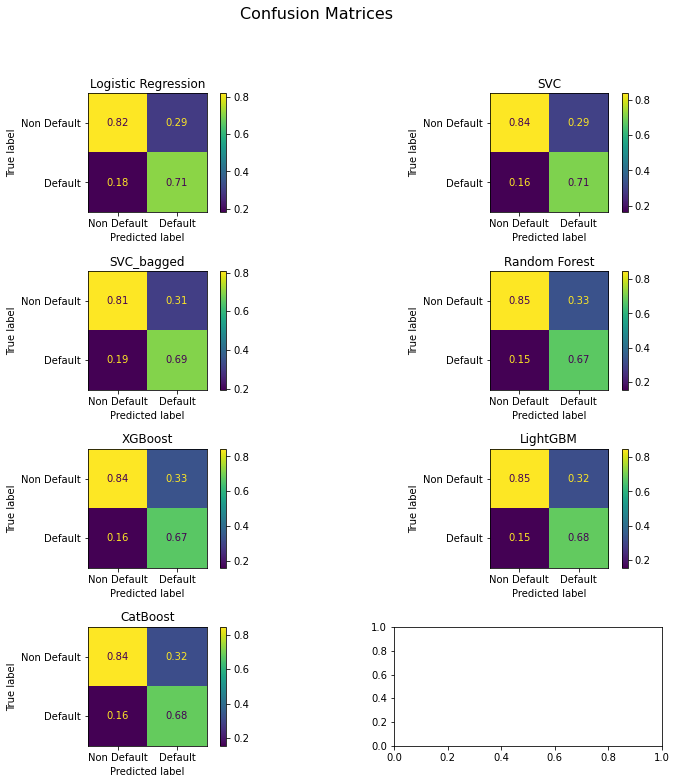

In [139]:
# Building Confusion Matrix

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 12))

fig.subplots_adjust(wspace = 0.5, hspace = 0.5 )

fig.suptitle("Confusion Matrices", horizontalalignment='center',
             fontsize=16)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
labels = ["Non Default", "Default"]

for (k, m), ax in zip(models.items(), axes):
    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);
    y_pred = pipe.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = ax, 
                                            display_labels=labels, normalize = 'pred')
    ax.set_title(f"{k}")

fig;

In [143]:
models['SVC'] = SVC(random_state=random_seed, probability= True)
models['SVC_bagged'] =  BaggingClassifier(
        SVC(random_state=random_seed,
            kernel='linear', probability=True, class_weight='balanced'), 
            max_samples=1.0 / n_estimators, n_estimators=n_estimators)

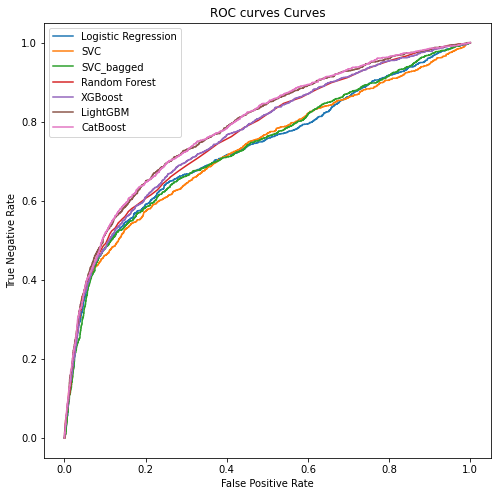

In [157]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():
   
    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = roc_curve(
        y_test, pipe.predict_proba(X_test)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("ROC curves Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend(loc="best");

### Default Hyper-Parameters and a tactic for Class Imbalancing: SMOTE. 

SMOTE is an over-sampling approach in which the minority class is over-sampled by creating "synthetic" examples by implementing k-nearest neighbor (Nitesh et al., 2002).

In [158]:
results_smote = {}
preds_smote = {}
for name, model in models.items():
    pipe = make_imb_pipeline(preprocessor,
                             SMOTE(),
                             model)
    tmp = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )
    results_smote[name] = tmp[0]
    preds_smote[name] = tmp[1]

In [159]:
results_3_3 = pd.DataFrame(results_smote).T
results_3_3

,fit_time,score_time,"test_profits, a=1/3","train_profits, a=1/3","test_profits, a=3/7","train_profits, a=3/7","test_profits, a=1/2","train_profits, a=1/2",test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.657 (+/- 0.031),0.051 (+/- 0.001),0.206 (+/- 0.004),0.207 (+/- 0.001),0.301 (+/- 0.004),0.302 (+/- 0.001),0.373 (+/- 0.004),0.374 (+/- 0.001),0.674 (+/- 0.006),0.676 (+/- 0.003),0.649 (+/- 0.014),0.652 (+/- 0.004),0.366 (+/- 0.007),0.368 (+/- 0.003),0.722 (+/- 0.011),0.725 (+/- 0.001)
SVC,479.855 (+/- 7.322),10.481 (+/- 0.094),0.205 (+/- 0.006),0.214 (+/- 0.001),0.301 (+/- 0.006),0.309 (+/- 0.001),0.372 (+/- 0.006),0.380 (+/- 0.001),0.776 (+/- 0.012),0.787 (+/- 0.002),0.568 (+/- 0.020),0.597 (+/- 0.006),0.495 (+/- 0.023),0.515 (+/- 0.004),0.756 (+/- 0.017),0.798 (+/- 0.002)
SVC_bagged,25.330 (+/- 0.187),2.996 (+/- 0.021),0.203 (+/- 0.006),0.204 (+/- 0.002),0.298 (+/- 0.006),0.299 (+/- 0.002),0.370 (+/- 0.006),0.371 (+/- 0.002),0.687 (+/- 0.010),0.687 (+/- 0.009),0.628 (+/- 0.023),0.632 (+/- 0.013),0.376 (+/- 0.010),0.377 (+/- 0.007),0.719 (+/- 0.010),0.722 (+/- 0.002)
Random Forest,8.120 (+/- 0.050),0.151 (+/- 0.001),0.188 (+/- 0.006),0.333 (+/- 0.000),0.283 (+/- 0.006),0.428 (+/- 0.000),0.354 (+/- 0.006),0.500 (+/- 0.000),0.799 (+/- 0.008),1.000 (+/- 0.000),0.462 (+/- 0.023),0.999 (+/- 0.000),0.553 (+/- 0.023),0.999 (+/- 0.000),0.754 (+/- 0.017),1.000 (+/- 0.000)
XGBoost,1.524 (+/- 0.013),0.069 (+/- 0.003),0.176 (+/- 0.005),0.222 (+/- 0.002),0.271 (+/- 0.005),0.317 (+/- 0.002),0.342 (+/- 0.005),0.389 (+/- 0.002),0.808 (+/- 0.009),0.878 (+/- 0.002),0.388 (+/- 0.020),0.574 (+/- 0.010),0.602 (+/- 0.034),0.819 (+/- 0.005),0.755 (+/- 0.015),0.928 (+/- 0.003)
LightGBM,0.606 (+/- 0.024),0.066 (+/- 0.004),0.182 (+/- 0.003),0.193 (+/- 0.002),0.277 (+/- 0.003),0.288 (+/- 0.002),0.348 (+/- 0.003),0.360 (+/- 0.002),0.813 (+/- 0.008),0.832 (+/- 0.001),0.416 (+/- 0.013),0.461 (+/- 0.008),0.612 (+/- 0.031),0.676 (+/- 0.005),0.770 (+/- 0.015),0.843 (+/- 0.002)
CatBoost,8.465 (+/- 0.062),0.082 (+/- 0.005),0.177 (+/- 0.004),0.200 (+/- 0.001),0.272 (+/- 0.004),0.295 (+/- 0.001),0.344 (+/- 0.004),0.366 (+/- 0.001),0.816 (+/- 0.007),0.851 (+/- 0.001),0.387 (+/- 0.017),0.479 (+/- 0.005),0.639 (+/- 0.028),0.758 (+/- 0.003),0.769 (+/- 0.015),0.889 (+/- 0.001)


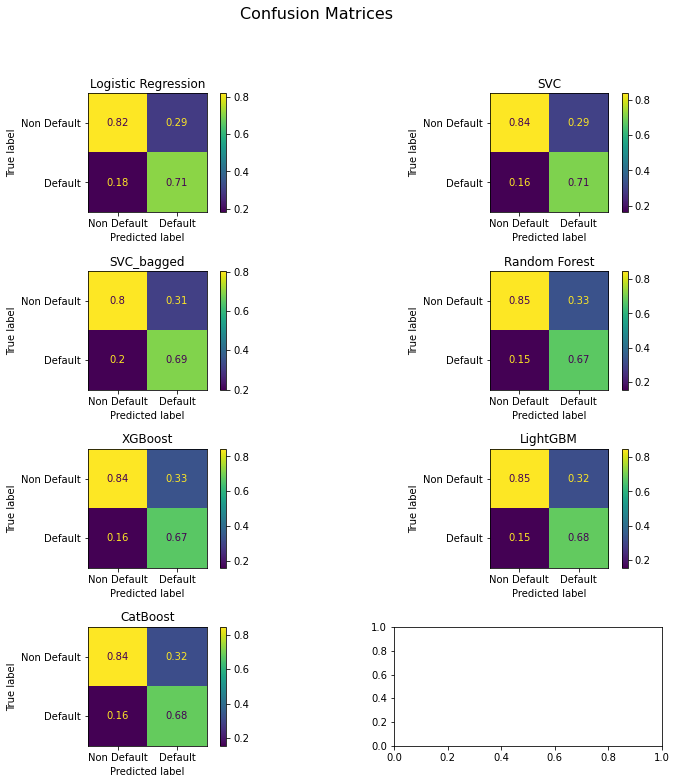

In [160]:
# Building Confusion Matrix

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 12))

fig.subplots_adjust(wspace = 0.5, hspace = 0.5 )

fig.suptitle("Confusion Matrices", horizontalalignment='center',
             fontsize=16)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
labels = ["Non Default", "Default"]

for (k, m), ax in zip(models.items(), axes):
    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);
    y_pred = pipe.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = ax, 
                                            display_labels=labels, normalize = 'pred')
    ax.set_title(f"{k}")

fig;

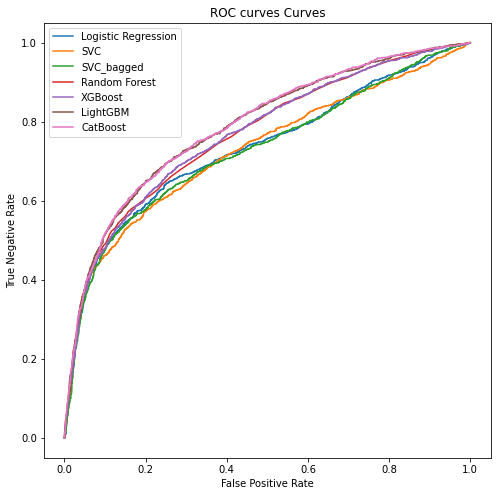

In [161]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():
   
    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = roc_curve(
        y_test, pipe.predict_proba(X_test)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("ROC curves Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend(loc="best");

### Hyperparameter Tunning of LGBM with SMOTE

Since we know that SMOTE get better results, we are going to use it for all Hyperparameter Tunning from here on.
<br>

In [162]:
# Light GBM
pipe_lgbm = make_imb_pipeline(preprocessor, SMOTE(), LGBMClassifier(random_state=123))

#params = {
#    "lgbmclassifier__boosting_type": ['gbdt', 'dart'],
#    "lgbmclassifier__num_leaves ": randint(low=10, high=2000),
#    "lgbmclassifier__n_estimators":randint(low=10, high=2000),
#    "lgbmclassifier__class_weight": [None, "balanced"]
#}

params = {
    "lgbmclassifier__boosting_type":  ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=5, high=5000),
    "lgbmclassifier__n_estimators":randint(low=5, high=5000),
    "lgbmclassifier__class_weight": [None, "balanced"],
    #"lgbmclassifier__num_iterations" : [1000,1001],
    #"lgbmclassifier__early_stopping_round" : [50,51],
    "lgbmclassifier__max_bin": randint(low=5, high=1000),
    "lgbmclassifier__eta": uniform(0, 0.9),
    "lgbmclassifier__min_gain_to_split": uniform(0, 0.5)
    
}

search_v1 = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring= f1_micro,
    random_state=123,
)

search_v1.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 609
[LightGBM] [Warning] min_gain_to_split is set=0.3758219943964592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3758219943964592
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.14133170557511926 will be ignored. Current value: learning_rate=0.1


In [163]:
search_v1.best_params_

{'lgbmclassifier__boosting_type': 'dart',
 'lgbmclassifier__class_weight': None,
 'lgbmclassifier__eta': 0.14133170557511926,
 'lgbmclassifier__max_bin': 749,
 'lgbmclassifier__min_gain_to_split': 0.3758219943964592,
 'lgbmclassifier__n_estimators': 3121,
 'lgbmclassifier__num_leaves ': 609}

In [ ]:
# save the model to disk
filename = 'LightGBM_hp_100i_v1_smote.sav'
pickle.dump(search_v1, open(filename, 'wb'))

In [185]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   SMOTE(),
                                   LGBMClassifier(
                                       random_state=123,
                                       boosting_type = search_v1.best_params_['lgbmclassifier__boosting_type'],
                                       class_weight = search_v1.best_params_['lgbmclassifier__class_weight'], 
                                       learning_rate = search_v1.best_params_['lgbmclassifier__eta'],
                                       max_bin = search_v1.best_params_['lgbmclassifier__max_bin'],
                                       min_split_gain = search_v1.best_params_['lgbmclassifier__min_gain_to_split'],
                                       n_estimators = search_v1.best_params_['lgbmclassifier__n_estimators'],
                                       num_leaves = search_v1.best_params_['lgbmclassifier__num_leaves ']))
pipe_lgbm_best.fit(X_train, y_train);

#### Results summarized

In [186]:
print(
    f"Grid Search best model validation score f1 score: {round(search_v1.best_score_, 3)}"
)
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Grid Search best model validation score f1 score: 0.815
Test f1 score - micro-average:  0.82
Test Accuracy score: 0.82
Test Recall score: 0.419
Test ROC_AUC score: 0.677
Test precision score: 0.65


In [187]:
print(f"Bank Profit alpha=1/3: {round(bank_profit_f1(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Bank Profit alpha=3/7: {round(bank_profit_f2(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Bank Profit alpha=1/2: {round(bank_profit_f3(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Bank Profit alpha=1/3: 0.182
Bank Profit alpha=3/7: 0.278
Bank Profit alpha=1/2: 0.349


#### Results analyzed

- If we compare this profits results with subsections 3.2 and 3.3 we can see that using F1-score as a loss function doesn't improve profit results under any alpha. 

#### Feature importance

In [188]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [189]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Feature importance for train sample


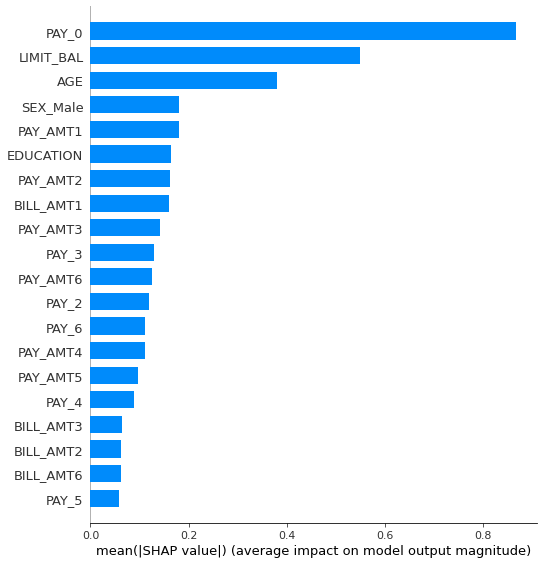

In [191]:
print("Feature importance for train sample")
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

Feature importance for test sample


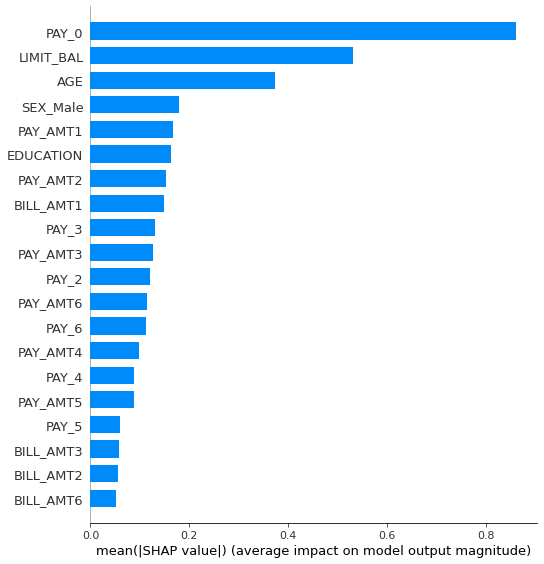

In [192]:
print("Feature importance for test sample")
shap.summary_plot(test_lgbm_shap_values[1], X_test_enc, plot_type="bar")

### Hyperparameter Tunning LGBM - custom loss function and SMOTE

In [195]:
# Light GBM
#params0 = {'num_iterations': 1000, 'early_stopping_round': 10}
#pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123,**params0))
pipe_lgbm = make_imb_pipeline(preprocessor, SMOTE(),LGBMClassifier(random_state=123))

params = {
    "lgbmclassifier__boosting_type":  ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=5, high=5000),
    "lgbmclassifier__n_estimators":randint(low=5, high=5000),
    "lgbmclassifier__class_weight": [None, "balanced"],
    #"lgbmclassifier__num_iterations" : [1000,1001],
    #"lgbmclassifier__early_stopping_round" : [50,51],
    "lgbmclassifier__max_bin": randint(low=5, high=1000),
    "lgbmclassifier__eta": uniform(0, 0.9),
    "lgbmclassifier__min_gain_to_split": uniform(0, 0.5)
    
}
#min_gain_to_split 
# max_delta_step 
search_v2 = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=100,
    return_train_score=True,
    scoring= bank_profit1,
    random_state=123,
)

In [196]:
search_v2.fit(X_train, y_train);
#~50 min

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 3474
[LightGBM] [Warning] min_gain_to_split is set=0.0923932246577146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0923932246577146
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.6701539159410579 will be ignored. Current value: learning_rate=0.1


In [227]:
# Print the tuned parameters and score
print(search_v2.best_params_)
print(search_v2.best_score_)

{'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__eta': 0.6701539159410579, 'lgbmclassifier__max_bin': 27, 'lgbmclassifier__min_gain_to_split': 0.0923932246577146, 'lgbmclassifier__n_estimators': 76, 'lgbmclassifier__num_leaves ': 3474}
0.19907118336741797


In [198]:
# save the model to disk
filename = 'LightGBM_hp_100i_v2_smote.sav'
pickle.dump(search_v2, open(filename, 'wb'))

In [199]:
# load the model from disk
search_v2 = pickle.load(open(filename, 'rb'))

In [200]:
# Preprocessing and transformations
numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']
categorical_features = ["MARRIAGE"]
binary_features = ["SEX"]
ordinal_features = ["EDUCATION"]
education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']

# preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

pipe_lgbm_base = make_imb_pipeline(preprocessor,SMOTE(),LGBMClassifier(random_state=124))
pipe_lgbm_base.fit(X_train, y_train);

In [216]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   SMOTE(),
                                   LGBMClassifier(
                                       random_state=123,
                                       boosting_type = search_v2.best_params_['lgbmclassifier__boosting_type'],
                                       class_weight = search_v2.best_params_['lgbmclassifier__class_weight'], 
                                       learning_rate = search_v2.best_params_['lgbmclassifier__eta'],
                                       max_bin = search_v2.best_params_['lgbmclassifier__max_bin'],
                                       min_split_gain = search_v2.best_params_['lgbmclassifier__min_gain_to_split'],
                                       n_estimators = search_v2.best_params_['lgbmclassifier__n_estimators'],
                                       num_leaves = search_v2.best_params_['lgbmclassifier__num_leaves ']))
pipe_lgbm_best.fit(X_train, y_train);
#~1 min

#### Results summarized

In [217]:
print("Basic LGBM results")
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_base.predict(X_test), average= 'micro'), 4)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")

Basic LGBM results
Test f1 score - micro-average:  0.816
Test Accuracy score: 0.816
Test Recall score: 0.439
Test ROC_AUC score: 0.6814
Test precision score: 0.6227


In [218]:
print(f"Bank Profit alpha=1/3: {round(bank_profit_f1(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Bank Profit alpha=3/7: {round(bank_profit_f2(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Bank Profit alpha=1/2: {round(bank_profit_f3(y_test, pipe_lgbm_base.predict(X_test)), 4)}")

Bank Profit alpha=1/3: 0.1853
Bank Profit alpha=3/7: 0.2805
Bank Profit alpha=1/2: 0.3519


In [219]:
print("LGBM results using Hyperparameter Tunning")
print(
    f"Grid Search best model validation score f1 score: {round(search_v2.best_score_, 4)}"
)
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 4)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")


LGBM results using Hyperparameter Tunning
Grid Search best model validation score f1 score: 0.1991
Test f1 score - micro-average:  0.7853
Test Accuracy score: 0.7853
Test Recall score: 0.4569
Test ROC_AUC score: 0.6681
Test precision score: 0.52


In [169]:
print(f"Bank Profit alpha=1/3: {round(bank_profit_f1(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Bank Profit alpha=3/7: {round(bank_profit_f2(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Bank Profit alpha=1/2: {round(bank_profit_f3(y_test, pipe_lgbm_best.predict(X_test)), 4)}")

Bank Profit alpha=1/3: 0.1799
Bank Profit alpha=3/7: 0.2751
Bank Profit alpha=1/2: 0.3466


#### Results analized

We can see that after a considerable Hyperparameter Tunning LGMB using an specific function for Profits doesn't give better results. This could be expected when the real model is simple and doesn't require more complex models. On the other hand those results could have less variance under cross-validation, a computation that should be analyzed.

#### Feature importance

In [221]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()

In [222]:
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [223]:
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [224]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Feature importance for train sample


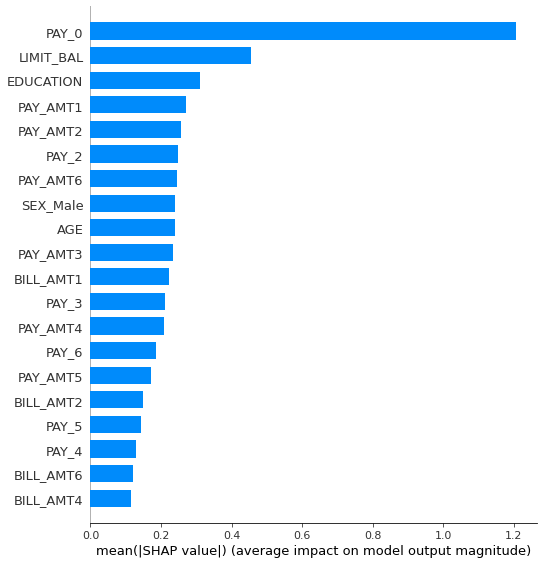

In [228]:
print("Feature importance for train sample")
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

Feature importance for test sample


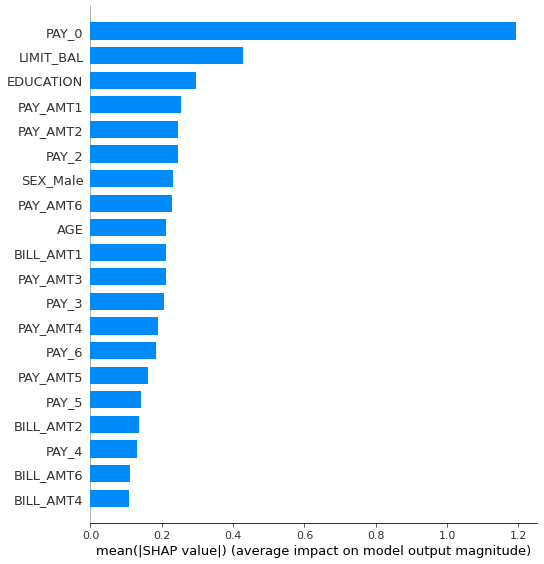

In [229]:
print("Feature importance for test sample")
shap.summary_plot(test_lgbm_shap_values[1], X_test_enc, plot_type="bar")

## Hypterparameter Tunning CatBoost - custom loss funcion and SMOTE

In [208]:
random_seed = 1
cbc = CatBoostClassifier(verbose=0, random_state=random_seed,
                        custom_metric='AUC',
                        early_stopping_rounds = 50,
                        grow_policy = 'Lossguide')

In [209]:
pipe_cbc = make_imb_pipeline(preprocessor,SMOTE(), cbc)

In [210]:
# Creating the hyperparameter grid
hparam_grid = {"learning_rate": uniform(0.01,.95),
               "max_depth": randint(3, 16),
               "iterations": randint(10, 100),
               #'max_depth_maximum_depth_of_trees': randint(5,16),
               'min_child_samples': randint(1, 10000),
               'colsample_bylevel' : uniform(0.01,.99),
               'l2_leaf_reg': randint(1, 10000),
               'random_strength': uniform(0.01,2),
               'bagging_temperature': uniform(0.01,10000)
               #'grow_policy': ['SymmetricTree','Depthwise','Lossguide']
              }

In [211]:
X_train_enc=preprocessor.transform(X_train)

In [212]:
rscv_cbc = RandomizedSearchCV(cbc, 
                              hparam_grid, 
                              scoring=bank_profit1, 
                              n_iter = 4000, 
                              cv =5, 
                              n_jobs=-1)

In [ ]:
rscv_cbc.fit(X_train_enc, y_train)
#~40 mins

In [215]:
# save the model to disk
filename = 'CatBoost_hp_100i_v1_smote.sav'
pickle.dump(rscv_cbc, open(filename, 'wb'))

In [214]:
# Print the tuned parameters and score
print(rscv_cbc.best_params_)
print(rscv_cbc.best_score_)

{'bagging_temperature': 2688.7952273518513, 'colsample_bylevel': 0.7083080508886705, 'iterations': 11, 'l2_leaf_reg': 9582, 'learning_rate': 0.8567642537093004, 'max_depth': 15, 'min_child_samples': 9638, 'random_strength': 0.3803423652362323}
0.17795457160653133


## Conclusions

Class Imbalance is a very common issue in the daily application of statistical methods to a broad range of problems. Here we tried to SOMTE from Nitesh et al. (2002) and a custom loss function for model selection during Hyperparameter Tunning (HPT) for LightGBM and CatBoost. We only found an improvement over no HPT (both with SMOTE) on LightGBM with our custom function for alfa = 1/3 improving from 0.1853 to 0.1991, a modest increase of 7.44%. We found no improvement on the rest of our models. Considering the importance of this area of research and the vast numerous of options to assess it we believe that more studies are needed to understand it and write more user-friendly codes.

# Bibliography

- Nitesh V Chawla, Kevin W Bowyer, Lawrence O Hall, and W Philip Kegelmeyer. (2002). Smote: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16:321–357.